# Project

## Predicting CFB Teams final AP Poll Ranking 

### Data Aggregation and merging

In [2]:
import pandas as pd
from pathlib import Path


# Directory and file-year mapping
base_path = Path('data/')
years = range(2013, 2024)
file_info = [(base_path / f'cfb{year % 100:02d}.csv', year) for year in years]

dfs = []
common_cols = None

# First pass to normalize columns and collect common columns
for path, year in file_info:
    df = pd.read_csv(path)
    
    # Normalize column names (e.g., "Off.Rank" -> "Off Rank")
    df.columns = df.columns.str.replace('.', ' ', regex=False).str.strip()
    
    # Add year column
    df['year'] = year

    # Track common columns
    cols = set(df.columns)
    common_cols = cols if common_cols is None else common_cols & cols
    
    dfs.append(df)

# Ensure 'year' and 'Team' are in the final common columns
required_cols = ['year', 'Team']
common_cols.update(required_cols)
common_cols = list(common_cols)

# Trim each DataFrame to only the common columns and concatenate
merged_df = pd.concat([df[common_cols].copy() for df in dfs], ignore_index=True)

# Reorder: year, Team, then all others alphabetically
ordered_cols = ['year', 'Team'] + sorted(col for col in merged_df.columns if col not in ['year', 'Team'])
merged_df = merged_df[ordered_cols]

# Save merged CSV
merged_df.to_csv(base_path / 'cfb_merged.csv', index=False)

print(merged_df.head())


   year                  Team Assist Tackle For Loss Average Sacks per Game  \
0  2013           Akron (MAC)                     32                   2.25   
1  2013         Alabama (SEC)                     32                   1.31   
2  2013      Arizona (Pac-12)                     28                   1.31   
3  2013  Arizona St. (Pac-12)                     32                   2.93   
4  2013        Arkansas (SEC)                     30                   0.67   

  Average Time of Possession per Game Avg Points per Game Allowed  \
0                               29:20                        28.6   
1                               32:00                        13.9   
2                               28:30                        24.2   
3                               30:21                        26.6   
4                               30:26                        30.8   

  Avg Turnover Margin per Game Avg Yard per Kickoff Return  \
0                        -0.17                  

### Adding Ranks Column 

In [3]:
import re

# -----------------------------
# Step 1: Load and process final polls
# -----------------------------

def clean_columns(df):
    df.columns = df.columns.str.strip()
    return df

def identify_column(df, keyword_list):
    return next((col for col in df.columns if any(k in col.lower() for k in keyword_list)), None)

def load_poll_data(poll_files):
    rankings = []

    for path, year in poll_files:
        df = clean_columns(pd.read_csv(path))
        
        week_col = identify_column(df, ['week'])
        team_col = identify_column(df, ['school', 'team'])
        rank_col = identify_column(df, ['rank'])

        final_week = df[week_col].max()
        final_df = df[df[week_col] == final_week][[team_col, rank_col]].copy()
        final_df.columns = ['Team', 'Final Rank']
        final_df['year'] = year

        rankings.append(final_df)

    all_ranks = pd.concat(rankings, ignore_index=True)
    all_ranks.drop_duplicates(subset=['Team', 'year'], inplace=True)
    all_ranks['Team'] = all_ranks['Team'].str.strip().str.lower()

    return all_ranks

# Set base path and file info
base_path = Path("data/")
poll_files = [(base_path / f"Poll {year % 100:02d}.csv", year) for year in range(2013, 2024)]

# Load all final poll rankings
final_ranks_df = load_poll_data(poll_files)

# -----------------------------
# Step 2: Load and clean main dataset
# -----------------------------

def remove_conference(name):
    return re.sub(r"\s*\(.*?\)", "", name).strip()

cfb_df = pd.read_csv(base_path / "cfb_merged.csv")
cfb_df['Team'] = cfb_df['Team'].apply(remove_conference).str.strip().str.lower()

# -----------------------------
# Step 3: Merge rankings into main dataset
# -----------------------------

merged_df = pd.merge(cfb_df, final_ranks_df, on=['Team', 'year'], how='left')

# -----------------------------
# Step 4: Check unmatched teams
# -----------------------------

unmatched = merged_df['Final Rank'].isna().sum()
print(f"Unmatched teams (likely unranked): {unmatched}")

# -----------------------------
# Optional: Save or view
# -----------------------------
# merged_df.to_csv(base_path / "cfb_final_with_ranks.csv", index=False)

print(merged_df[['year', 'Team', 'Final Rank']].head())

Unmatched teams (likely unranked): 1149
   year         Team  Final Rank
0  2013        akron         NaN
1  2013      alabama         3.0
2  2013      arizona         NaN
3  2013  arizona st.         NaN
4  2013     arkansas         NaN


### Adding Conference Column

In [4]:
# ---------------------------------------------
# Set your file path
# ---------------------------------------------
base_path = Path("data/")

# ---------------------------------------------
# Load the merged dataset (assumes already in memory or reloads)
# ---------------------------------------------
cfb_df = merged_df.copy()  # or pd.read_csv(base_path / "cfb_merged.csv")

# ---------------------------------------------
# Team name cleaning and correction
# ---------------------------------------------
def clean_team(name):
    return re.sub(r"\s*\(.*?\)", "", str(name)).strip().lower()

team_corrections = {
    "arizona st.": "arizona state",
    "arkansas st.": "arkansas state",
    "army west point": "army",
    "ball st.": "ball state",
    "central mich.": "central michigan",
    "e. michigan": "eastern michigan",
    "fla. atlantic": "florida atlantic",
    "fla. intl.": "florida international",
    "florida st.": "florida state",
    "georgia st.": "georgia state",
    "kent st.": "kent state",
    "louisiana": "louisiana-lafayette",
    "louisiana-monroe": "ul-monroe",
    "massachusetts": "umass",
    "miami (oh)": "miami oh",
    "miami (fl)": "miami",
    "middle tenn.": "middle tennessee",
    "mississippi st.": "mississippi state",
    "nc state": "north carolina state",
    "n. illinois": "northern illinois",
    "oklahoma st.": "oklahoma state",
    "oregon st.": "oregon state",
    "penn st.": "penn state",
    "san diego st.": "san diego state",
    "san jose st.": "san jose state",
    "southern miss.": "southern miss",
    "troy": "troy university",
    "uab": "alabama-birmingham",
    "ucf": "central florida",
    "uconn": "connecticut",
    "umass": "massachusetts",
    "unlv": "nevada-las vegas",
    "usc": "southern california",
    "utep": "texas-el paso",
    "utsa": "texas-san antonio",
    "western kentucky": "w. kentucky",
    "western mich.": "western michigan"
}

def standardize_team_column(df, col='Team'):
    df[col] = df[col].apply(clean_team)
    df[col] = df[col].replace(team_corrections)
    return df

cfb_df = standardize_team_column(cfb_df)

# ---------------------------------------------
# Load and combine all conference files
# ---------------------------------------------
conference_frames = []
for year in range(2013, 2024):
    file_path = base_path / f"Conference {year}.csv"
    if file_path.exists():
        df = pd.read_csv(file_path)
        df.columns = df.columns.str.strip()
        df.rename(columns={'School': 'Team'}, inplace=True)
        df = standardize_team_column(df)
        df['year'] = year
        conference_frames.append(df[['Team', 'year', 'Conference']])

conference_df = pd.concat(conference_frames, ignore_index=True)

# ---------------------------------------------
# Merge conference info into main dataset
# ---------------------------------------------
merged_df = pd.merge(cfb_df, conference_df, on=['Team', 'year'], how='left')

# ---------------------------------------------
# Save result
# ---------------------------------------------
output_path = base_path / "cfb_merged_with_conference.csv"
merged_df.to_csv(output_path, index=False)
print(f"Merged dataset saved to: {output_path.name}")

Merged dataset saved to: cfb_merged_with_conference.csv


## EDA

Shape of dataset: (1397, 139)

Top missing values:
Prediction Error          1166
Actual Rank               1166
Final Rank                1166
Safety                       0
Sacks                        0
Scoring Def Rank             0
Sack Yards                   0
Sack Rank                    0
Rushing Yards per Game       0
Redzone Points Allowed       0
dtype: int64


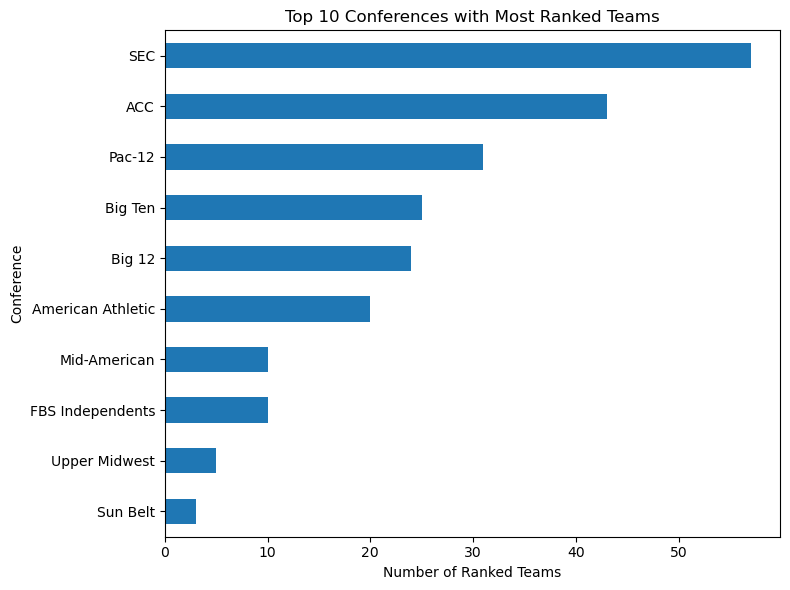

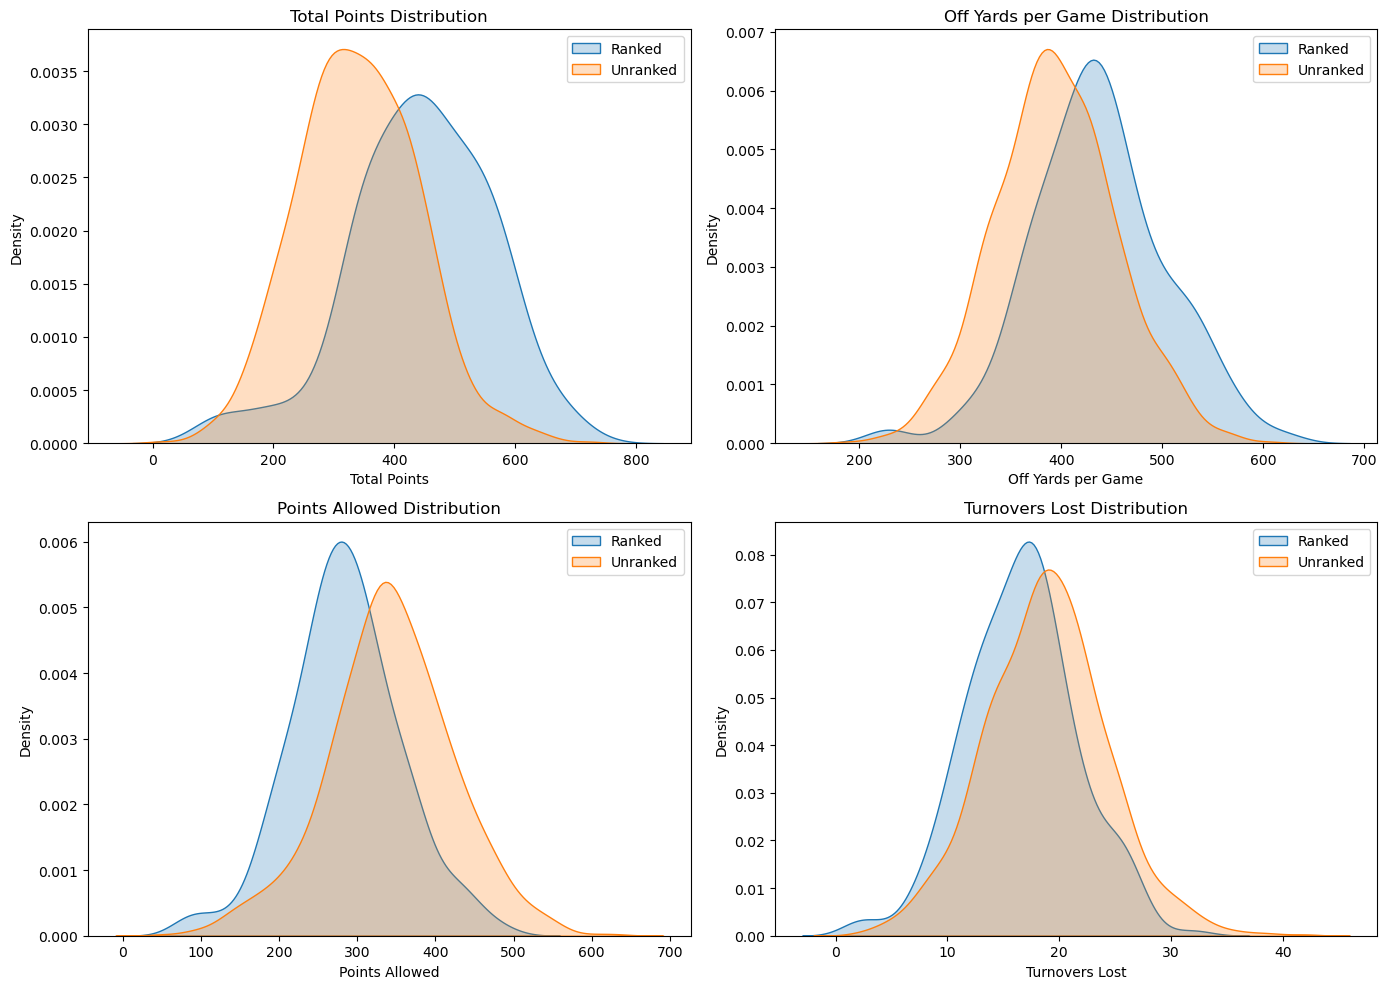


Top 10 strongest (negative) correlations with Final Rank:
Conference_Big 12             -0.205326
Conference_SEC                -0.163814
year                          -0.072604
Conference_Pac-12             -0.050038
Conference_Mid-American        0.010826
Conference_Big Ten             0.021593
Conference_FBS Independents    0.037367
Conference_Upper Midwest       0.102426
Conference_Sun Belt            0.125638
Conference_Conference USA      0.130939
Name: Final Rank, dtype: float64

Top 10 strongest positive correlations (worse rank):
Conference_Conference USA       0.130939
Conference_ACC                  0.131658
Conference_American Athletic    0.137314
Prediction Error                0.751915
Predicted Rank                  0.807883
Predicted Rank (RFE)            0.830231
Predicted Rank Score            0.919188
Predicted Rank Score (RFE)      0.927866
Final Rank                      1.000000
Actual Rank                     1.000000
Name: Final Rank, dtype: float64


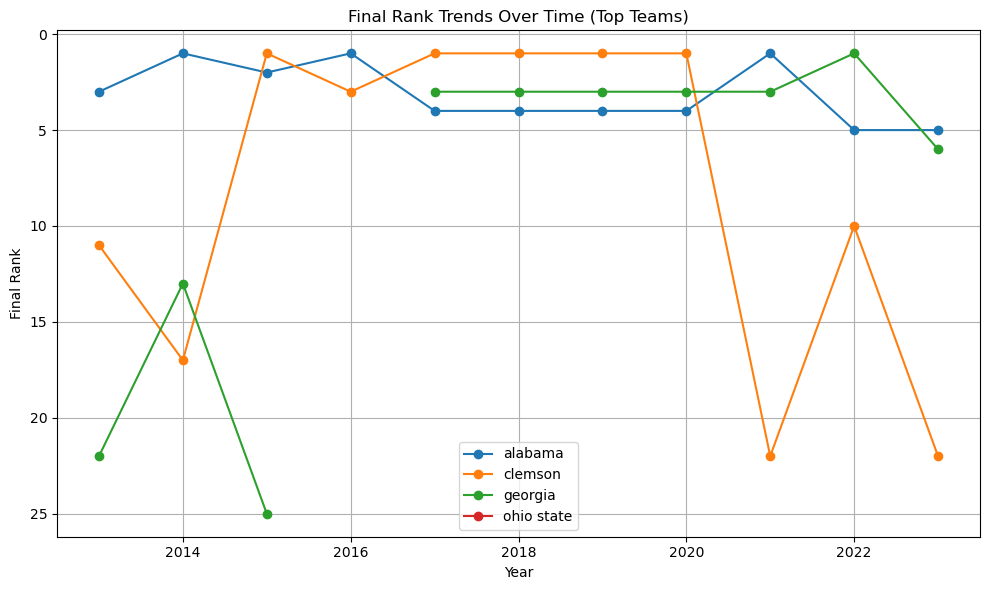

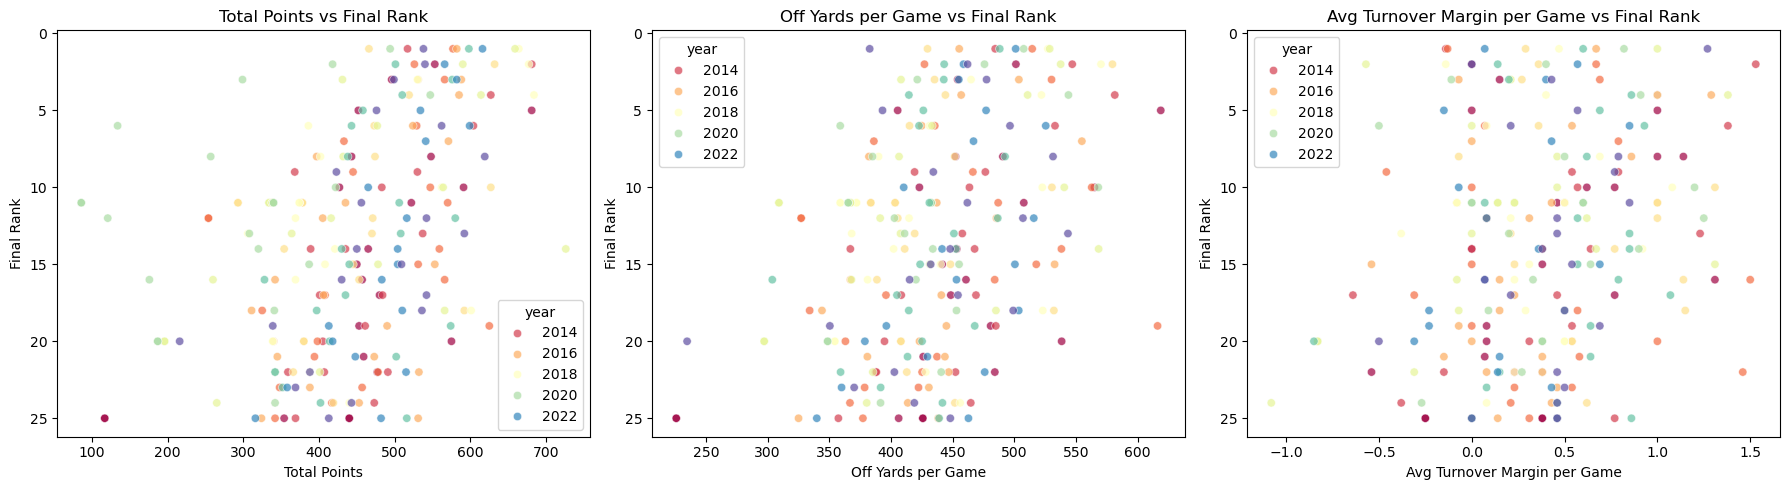

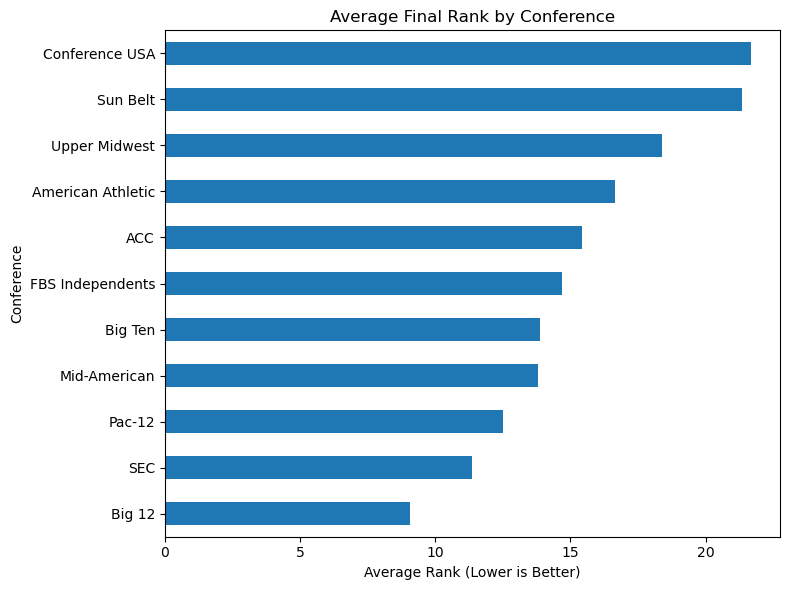

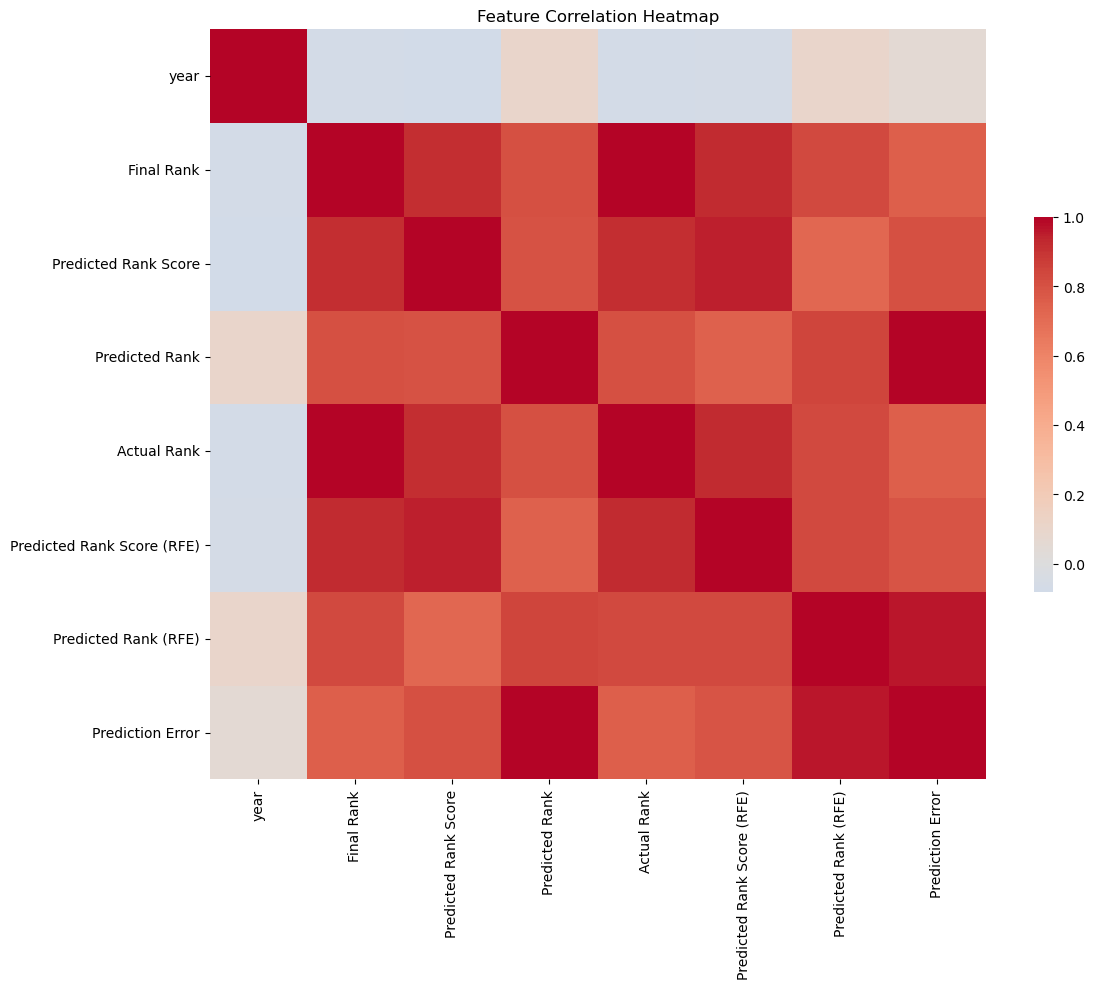

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# ----------------------
# 1. Basic Dataset Stats
# ----------------------
print("Shape of dataset:", merged_df.shape)
print("\nTop missing values:")
print(merged_df.isnull().sum().sort_values(ascending=False).head(10))

# ----------------------
# 2. Top Conferences by Ranked Teams
# ----------------------
plt.figure(figsize=(8, 6))
top_confs = merged_df[merged_df['Final Rank'].notna()]['Conference'].value_counts().head(10)
top_confs.plot(kind='barh')
plt.title('Top 10 Conferences with Most Ranked Teams')
plt.xlabel('Number of Ranked Teams')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# ----------------------
# 3. Feature Distributions: Ranked vs Unranked (Subplots)
# ----------------------
ranked = merged_df[merged_df['Final Rank'].notna()]
unranked = merged_df[merged_df['Final Rank'].isna()]
features_to_compare = ['Total Points', 'Off Yards per Game', 'Points Allowed', 'Turnovers Lost']

fig, axs = plt.subplots(2, 2, figsize=(14, 10))
for i, feature in enumerate(features_to_compare):
    ranked_feature = pd.to_numeric(ranked[feature], errors='coerce')
    unranked_feature = pd.to_numeric(unranked[feature], errors='coerce')
    ax = axs[i//2, i%2]
    sns.kdeplot(ranked_feature.dropna(), label='Ranked', fill=True, ax=ax)
    sns.kdeplot(unranked_feature.dropna(), label='Unranked', fill=True, ax=ax)
    ax.set_title(f'{feature} Distribution')
    ax.legend()
plt.tight_layout()
plt.show()

# ----------------------
# 4. Correlation with Final Rank
# ----------------------
corrs = merged_df.corr(numeric_only=True)['Final Rank'].dropna().sort_values()
print("\nTop 10 strongest (negative) correlations with Final Rank:")
print(corrs.head(10))
print("\nTop 10 strongest positive correlations (worse rank):")
print(corrs.tail(10))

# ----------------------
# 5. Rank Trends Over Time for Top Programs
# ----------------------
top_teams = ['alabama', 'clemson', 'georgia', 'ohio state']
plt.figure(figsize=(10, 6))
for team in top_teams:
    team_df = merged_df[merged_df['Team'] == team.lower()]
    plt.plot(team_df['year'], team_df['Final Rank'], marker='o', label=team)
plt.title('Final Rank Trends Over Time (Top Teams)')
plt.xlabel('Year')
plt.ylabel('Final Rank')
plt.gca().invert_yaxis()
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ----------------------
# 6. Feature vs Final Rank Scatterplots (Subplots)
# ----------------------
scatter_features = ['Total Points', 'Off Yards per Game', 'Avg Turnover Margin per Game']
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

for i, feature in enumerate(scatter_features):
    ranked_feature = pd.to_numeric(ranked[feature], errors='coerce')
    sns.scatterplot(
        x=ranked_feature,
        y=ranked['Final Rank'],
        hue=ranked['year'],
        palette='Spectral',
        alpha=0.7,
        ax=axs[i]
    )
    axs[i].set_title(f'{feature} vs Final Rank')
    axs[i].set_xlabel(feature)
    axs[i].set_ylabel('Final Rank')
    axs[i].invert_yaxis()

plt.tight_layout()
plt.show()

# ----------------------
# 7. Conference Performance: Avg Rank
# ----------------------
plt.figure(figsize=(8, 6))
avg_rank_conf = ranked.groupby('Conference')['Final Rank'].mean().sort_values()
avg_rank_conf.plot(kind='barh')
plt.title('Average Final Rank by Conference')
plt.xlabel('Average Rank (Lower is Better)')
plt.tight_layout()
plt.show()

# ----------------------
# 8. Heatmap of Feature Correlations
# ----------------------
plt.figure(figsize=(12, 10))
numeric_df = merged_df.select_dtypes(include='number')
sns.heatmap(numeric_df.corr(), cmap='coolwarm', center=0, cbar_kws={'shrink': .5})
plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.show()


### Model Creation

In [6]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import pandas as pd

# ---------------------------------------------
# STEP 3: Train a model on ranked teams
# ---------------------------------------------

# Filter ranked data
ranked_df = merged_df[merged_df['Final Rank'].notna()].copy()
ranked_df['Final Rank'] = ranked_df['Final Rank'].astype(int)

# One-hot encode 'Conference' in both ranked_df and merged_df
ranked_df = pd.get_dummies(ranked_df, columns=['Conference'], dummy_na=False)
merged_df = pd.get_dummies(merged_df, columns=['Conference'], dummy_na=False)

# Align conference columns between train and full data
conference_cols = [col for col in ranked_df.columns if col.startswith('Conference_')]
for col in conference_cols:
    if col not in merged_df.columns:
        merged_df[col] = 0

# Ensure merged_df has only the same conference columns as ranked_df
extra_cols = [col for col in merged_df.columns if col.startswith('Conference_') and col not in conference_cols]
merged_df.drop(columns=extra_cols, inplace=True)

# Reorder conference columns to match
merged_df = merged_df.reindex(columns=ranked_df.columns, fill_value=0)

# ---------------------------------------------
# STEP 4: Create Features and Train Model
# ---------------------------------------------

X = ranked_df.drop(columns=['Team', 'Final Rank', 'year'], errors='ignore')
X = X.apply(pd.to_numeric, errors='coerce').fillna(0)
y = ranked_df['Final Rank']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# ---------------------------------------------
# STEP 5: Predict for all teams and assign rank
# ---------------------------------------------

features = merged_df.drop(columns=['Team', 'Final Rank', 'year'], errors='ignore')
features = features.apply(pd.to_numeric, errors='coerce').fillna(0)
merged_df['Predicted Rank Score'] = model.predict(features)

# Assign unique predicted rank per year
merged_df['Predicted Rank'] = merged_df.groupby('year')['Predicted Rank Score']\
                                       .rank(method='first', ascending=True)\
                                       .astype(int)

# Create actual rank column
merged_df['Actual Rank'] = merged_df['Final Rank'].astype(pd.Int64Dtype())

# ---------------------------------------------
# STEP 6: Final Output
# ---------------------------------------------

final_output = merged_df[['year', 'Team', 'Predicted Rank', 'Actual Rank']]\
                  .sort_values(['year', 'Predicted Rank'])

final_output.to_csv("predicted_vs_actual_rankings.csv", index=False)
print(final_output.head(30))

# ---------------------------------------------
# STEP 7: Calculate RMSE
# ---------------------------------------------
y_test_pred = model.predict(X_test)
rmse = mean_squared_error(y_test, y_test_pred, squared=False)
print("Root Mean Squared Error (RMSE) on Test Set:", rmse)


     year            Team  Predicted Rank  Actual Rank
7    2013          auburn               1            2
9    2013          baylor               2            5
1    2013         alabama               3            3
25   2013   florida state               4         <NA>
71   2013          oregon               5           10
63   2013   northern ill.               6         <NA>
84   2013        stanford               7            5
56   2013        missouri               8            8
43   2013        marshall               9         <NA>
67   2013        ohio st.              10         <NA>
17   2013         clemson              11           11
20   2013   east carolina              12         <NA>
69   2013  oklahoma state              13         <NA>
3    2013   arizona state              14         <NA>
11   2013   bowling green              15         <NA>
68   2013        oklahoma              16           10
52   2013    michigan st.              17         <NA>
90   2013 

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


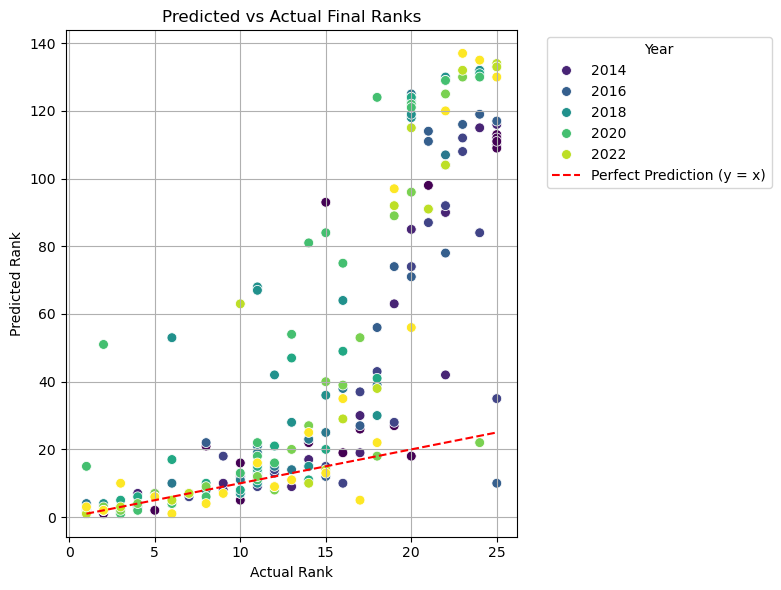

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter to rows with actual rank available
comparison_df = merged_df[merged_df['Actual Rank'].notna()].copy()

plt.figure(figsize=(8, 6))
sns.scatterplot(data=comparison_df, x='Actual Rank', y='Predicted Rank', hue='year', palette='viridis', s=50)

# Add reference line
plt.plot([1, 25], [1, 25], 'r--', label='Perfect Prediction (y = x)')

plt.title('Predicted vs Actual Final Ranks')
plt.xlabel('Actual Rank')
plt.ylabel('Predicted Rank')
plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(True)
plt.show()


**Figure.** Comparison of predicted vs. actual ranks for the 2023 season. A diagonal reference line is included to highlight prediction accuracy.


## Feature Importance/Selection

### Implementation of RFE

In [8]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Prepare clean numeric feature set
X_full = ranked_df.drop(columns=['Team', 'Final Rank', 'year'], errors='ignore')
X_full = X_full.apply(pd.to_numeric, errors='coerce').fillna(0)
y_full = ranked_df['Final Rank']

# Apply RFE
base_rf = RandomForestRegressor(n_estimators=100, random_state=42)
rfe_selector = RFE(estimator=base_rf, n_features_to_select=30, step=10)
rfe_selector.fit(X_full, y_full)

# Use selected features
selected_features_rfe = X_full.columns[rfe_selector.support_]
print("Selected features by RFE:", selected_features_rfe.tolist())

X_reduced = X_full[selected_features_rfe]

# Train/test split and model training
X_train_rfe, X_test_rfe, y_train_rfe, y_test_rfe = train_test_split(
    X_reduced, y_full, test_size=0.2, random_state=42
)

rfe_model = RandomForestRegressor(n_estimators=100, random_state=42)
rfe_model.fit(X_train_rfe, y_train_rfe)

# Predict and evaluate
y_test_pred_rfe = rfe_model.predict(X_test_rfe)
rmse_rfe = mean_squared_error(y_test_rfe, y_test_pred_rfe, squared=False)
print("Root Mean Squared Error (RMSE) using RFE-selected features:", rmse_rfe)

# Prepare full merged dataset for prediction using RFE-selected features
features_full = merged_df.drop(columns=['Team', 'Final Rank', 'year'], errors='ignore')
features_full = features_full.apply(pd.to_numeric, errors='coerce').fillna(0)

# Make sure only selected RFE features are used
features_reduced = features_full[selected_features_rfe]

# Predict using RFE model
merged_df['Predicted Rank Score (RFE)'] = rfe_model.predict(features_reduced)

# Assign predicted ranks within each year
merged_df['Predicted Rank (RFE)'] = merged_df.groupby('year')['Predicted Rank Score (RFE)']\
    .rank(method='first', ascending=True).astype(int)

# Final output table
final_output_rfe = merged_df[['year', 'Team', 'Predicted Rank (RFE)', 'Actual Rank']]\
    .sort_values(['year', 'Predicted Rank (RFE)'])

# Save to CSV
final_output_rfe.to_csv("predicted_vs_actual_rankings_rfe.csv", index=False)

# Show top 30 rows
print(final_output_rfe.head(30))

# Show RMSE
rmse = mean_squared_error(y_test, y_test_pred_rfe, squared=False)
print("Root Mean Squared Error (RMSE) on Test Set:", rmse)



Selected features by RFE: ['Assist Tackle For Loss', 'Avg Points per Game Allowed', 'Avg Turnover Margin per Game', 'Games', 'Kickoff Return Rank', 'Kickoff Return Yards', 'Off TDs', 'Off Yards', 'Off Yards per Game', 'Opp Net Punt Return Yards', 'Opp Pass Yds Allowed', 'Opp Punt Returns', 'Opp Redzone Rush TD Allowed', 'Opponent 3rd Percent', 'PAT', 'Points Allowed', 'Points Per Game', 'Redzone Points', 'Rush Attempts', 'Rush Yards Per Game Allowed', 'Rushing Def Rank', 'Rushing Off Rank', 'Scoring Def Rank', 'Scoring Off Rank', 'Total Points', 'Total TDs Allowed', 'Total Tackle For Loss', 'Touchdowns', 'Touchdowns Allowed', 'Yards Allowed']
Root Mean Squared Error (RMSE) using RFE-selected features: 5.15345205518654
     year            Team  Predicted Rank (RFE)  Actual Rank
7    2013          auburn                     1            2
1    2013         alabama                     2            3
9    2013          baylor                     3            5
67   2013        ohio st.   

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


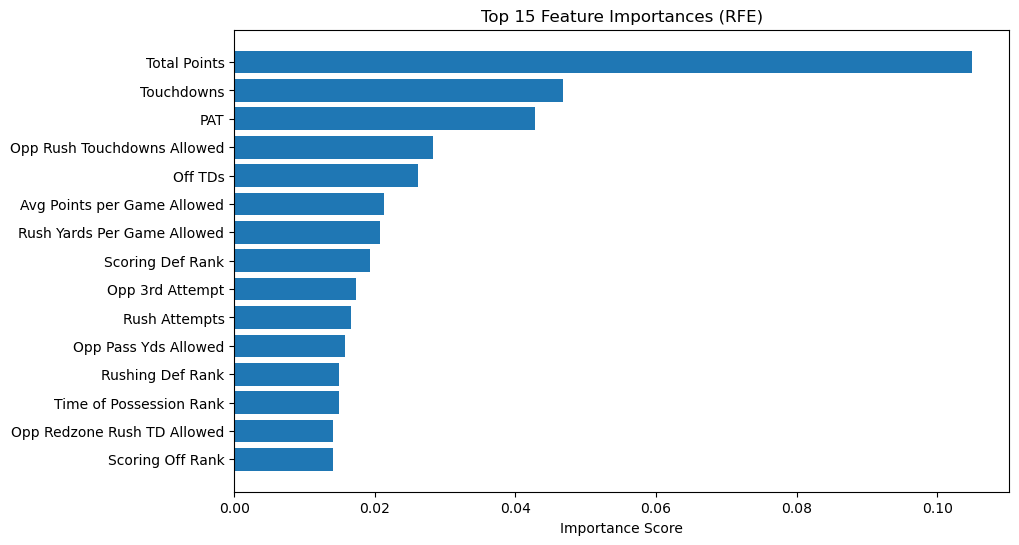

In [9]:
import matplotlib.pyplot as plt
import numpy as np 

importances = model.feature_importances_
indices = np.argsort(importances)[-15:]  # Top 15 features
plt.figure(figsize=(10,6))
plt.title("Top 15 Feature Importances (RFE)")
plt.barh(range(len(indices)), importances[indices])
plt.yticks(range(len(indices)), [X.columns[i] for i in indices])
plt.xlabel("Importance Score")
plt.show()


## Testing the effect of conference

Without Conference RMSE: 5.653720108373759
With Conference RMSE: 5.615650622580933


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


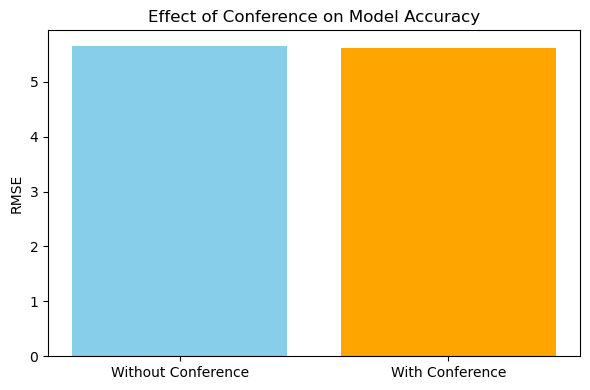

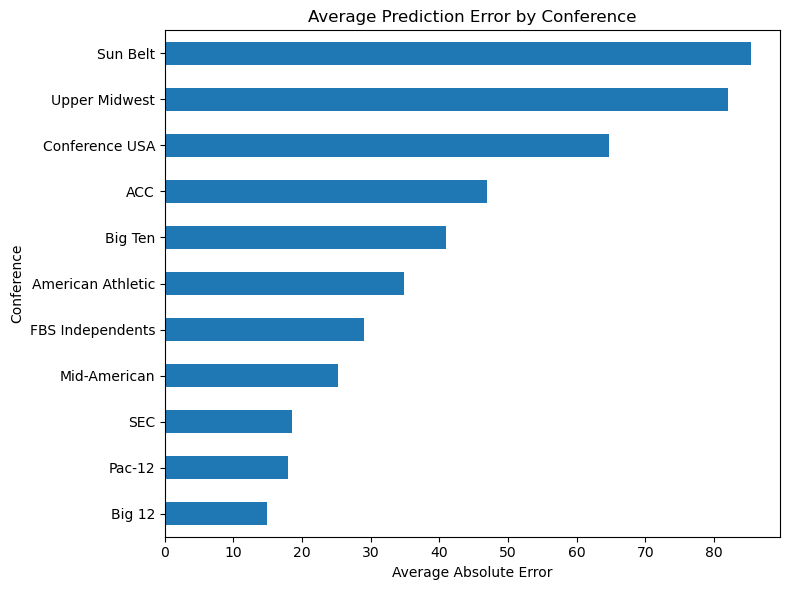

In [10]:
# Define which columns are conference indicators
conference_cols = [col for col in X.columns if col.startswith('Conference_')]
merged_df['Conference'] = merged_df[conference_cols].idxmax(axis=1).str.replace("Conference_", "")
# X without conference features
X_no_conf = X.drop(columns=conference_cols)
X_train_nc, X_test_nc, y_train_nc, y_test_nc = train_test_split(X_no_conf, y, test_size=0.2, random_state=42)

# Model WITHOUT conference
rf_nc = RandomForestRegressor(n_estimators=100, random_state=42)
rf_nc.fit(X_train_nc, y_train_nc)
y_pred_nc = rf_nc.predict(X_test_nc)
rmse_nc = mean_squared_error(y_test_nc, y_pred_nc, squared=False)

# Model WITH conference (already trained)
y_pred_with = model.predict(X_test)
rmse_with = mean_squared_error(y_test, y_pred_with, squared=False)

print("Without Conference RMSE:", rmse_nc)
print("With Conference RMSE:", rmse_with)


import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.bar(['Without Conference', 'With Conference'], [rmse_nc, rmse_with], color=['skyblue', 'orange'])
plt.ylabel('RMSE')
plt.title('Effect of Conference on Model Accuracy')
plt.tight_layout()
plt.show()

# Add error column
merged_df['Prediction Error'] = abs(merged_df['Actual Rank'] - merged_df['Predicted Rank'])

# Group and average by conference
avg_error_by_conf = merged_df[merged_df['Actual Rank'].notna()].groupby('Conference')['Prediction Error'].mean().sort_values()

# Plot
avg_error_by_conf.plot(kind='barh', figsize=(8, 6))
plt.xlabel("Average Absolute Error")
plt.title("Average Prediction Error by Conference")
plt.tight_layout()
plt.show()

